In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss, roc_auc_score, RocCurveDisplay, roc_curve
import numpy as np
import pandas as pd
from IMPJ import DataProcessor
import random
import matplotlib.pyplot as plt
from os.path import basename, exists
import matplotlib as mpl
import random
from tqdm import tqdm

randomstate = random.randint(1,1000) 

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/AstronomicalData/raw/main/' + 'az-paper-twocol.mplstyle')
plt.style.use('./az-paper-twocol.mplstyle')

In [2]:
dp = DataProcessor()

In [3]:
'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
hl_list = []
for i in range(1,100):
        for k in range(1,100):
               
                hl_list.append((i,k))
        
model_parameters = {
        'hidden_layer_sizes':hl_list,
        'activation':['tanh','relu'],
        'solver':['lbfgs','sgd','adam'],
        'learning_rate':['constant','invscaling','adaptive']
}
NN = MLPClassifier(random_state=1)
clf = RandomizedSearchCV(NN, model_parameters, n_jobs=-1, cv=20,scoring='roc_auc')
clf.fit(x_train, y_train)
#NN = MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate='constant', solver='sgd', random_state=1, max_iter=10000)

# All results
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_ )
print('Best Score (ROC-AUC) was: \n', clf.best_score_)'''


'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom skopt import BayesSearchCV\nhl_list = []\nfor i in range(1,100):\n        for k in range(1,100):\n               \n                hl_list.append((i,k))\n        \nmodel_parameters = {\n        \'hidden_layer_sizes\':hl_list,\n        \'activation\':[\'tanh\',\'relu\'],\n        \'solver\':[\'lbfgs\',\'sgd\',\'adam\'],\n        \'learning_rate\':[\'constant\',\'invscaling\',\'adaptive\']\n}\nNN = MLPClassifier(random_state=1)\nclf = RandomizedSearchCV(NN, model_parameters, n_jobs=-1, cv=20,scoring=\'roc_auc\')\nclf.fit(x_train, y_train)\n#NN = MLPClassifier(activation=\'relu\', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate=\'constant\', solver=\'sgd\', random_state=1, max_iter=10000)\n\n# All results\n#means = clf.cv_results_[\'mean_test_score\']\n#stds = clf.cv_results_[\'std_test_score\']\n#for mean, std, params in zip(means, stds, clf.cv_results_[\'params\'

In [4]:
test_size = 0.3

for x in range(1,2):
        
        # creating test and train data
        
        filepath = '..\\..\\Fermi-LAT Data\\imputed_wrappered_12_withbcus.csv'
        data = pd.read_csv(filepath, index_col=0)
        data=data.dropna()
        X,Y = dp.choose_2_vars('CLASS1',data,1,2)
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size) 
        
        # adding radio galaxies and bcus to the test set
        
        y_test=np.append(y_test,np.array(data['CLASS1'].loc[data['CLASS1']==3]))
        rdgs=data.loc[data['CLASS1']==3]
        rdg_xs=rdgs.drop('CLASS1',axis=1)
        bcus=data.loc[data['CLASS1']==0]
        bcus=bcus.replace(0,7)
        y_test=np.append(y_test,bcus['CLASS1'])
        bcu_xs=bcus.drop('CLASS1',axis=1)
        x_test=pd.concat([x_test,rdg_xs])
        x_test=pd.concat([x_test,bcu_xs])
        
        # scaling data
        
        scaler = StandardScaler()  
        scaler.fit(x_train)  
        x_train = scaler.transform(x_train)  
        x_test = scaler.transform(x_test)  

        # machine learning training and prediction

        NN = MLPClassifier(activation='tanh',hidden_layer_sizes=(50,50),learning_rate='adaptive',solver='sgd',max_iter=5000)
        BNN = BaggingClassifier(estimator=NN,n_estimators=20,bootstrap=True)
        BNN.fit(x_train,y_train)
        y_pred = BNN.predict(x_test)
        y_proba = BNN.predict_proba(x_test)

        # Saving Results

        y_proba0=np.array(y_proba).T[0]
        y_proba1=np.array(y_proba).T[1]
        y_results = pd.DataFrame(y_test,columns=['y_test'])
        y_results['y_pred']=y_pred
        y_results['y_proba_0']=y_proba0
        y_results['y_proba_1']=y_proba1
        y_results.to_csv('..\\..\\Results\\final_results\\bllvsfsrq\\Model Validation\\y_results_imputed_wrappered_12_run'+str(x)+'.csv')
        
        

In [5]:
for x in range(1,11):
        
        # creating train data (we will now use the entire dataset for training)
        
        filepath = '..\\..\\Fermi-LAT Data\\imputed_wrappered_12_withbcus.csv'
        data = pd.read_csv(filepath, index_col=0)
        data=data.dropna()
        X,Y = dp.choose_2_vars('CLASS1',data,1,2)
        x_train = X
        y_train = Y

        # Creating a BCU only dataset to apply the trained model to

        bcus=data.loc[data['CLASS1']==0]
        x_bcus = bcus.drop('CLASS1',axis=1)
        
        # scaling data

        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_bcus = scaler.transform(x_bcus)

        # Training and applying the ML model

        NN = MLPClassifier(activation='tanh',hidden_layer_sizes=(50,50),learning_rate='adaptive',solver='sgd',max_iter=5000)
        BNN = BaggingClassifier(estimator=NN,n_estimators=20,bootstrap=True)
        BNN.fit(x_train,y_train)
        y_pred = BNN.predict(x_bcus)
        y_proba = BNN.predict_proba(x_bcus)

        # Saving the results

        y_proba0=np.array(y_proba).T[0]
        y_proba1=np.array(y_proba).T[1]
        y_results = pd.DataFrame(index=bcus.index)
        y_results['y_pred']=y_pred
        y_results['y_proba_0']=y_proba0
        y_results['y_proba_1']=y_proba1
        y_results.to_csv('..\\..\\Results\\final_results\\bllvsfsrq\\Final Results\\y_results_imputed_wrappered_12_run'+str(x)+'.csv')
        


(2370, 12)


Text(0.5, 1.0, '')

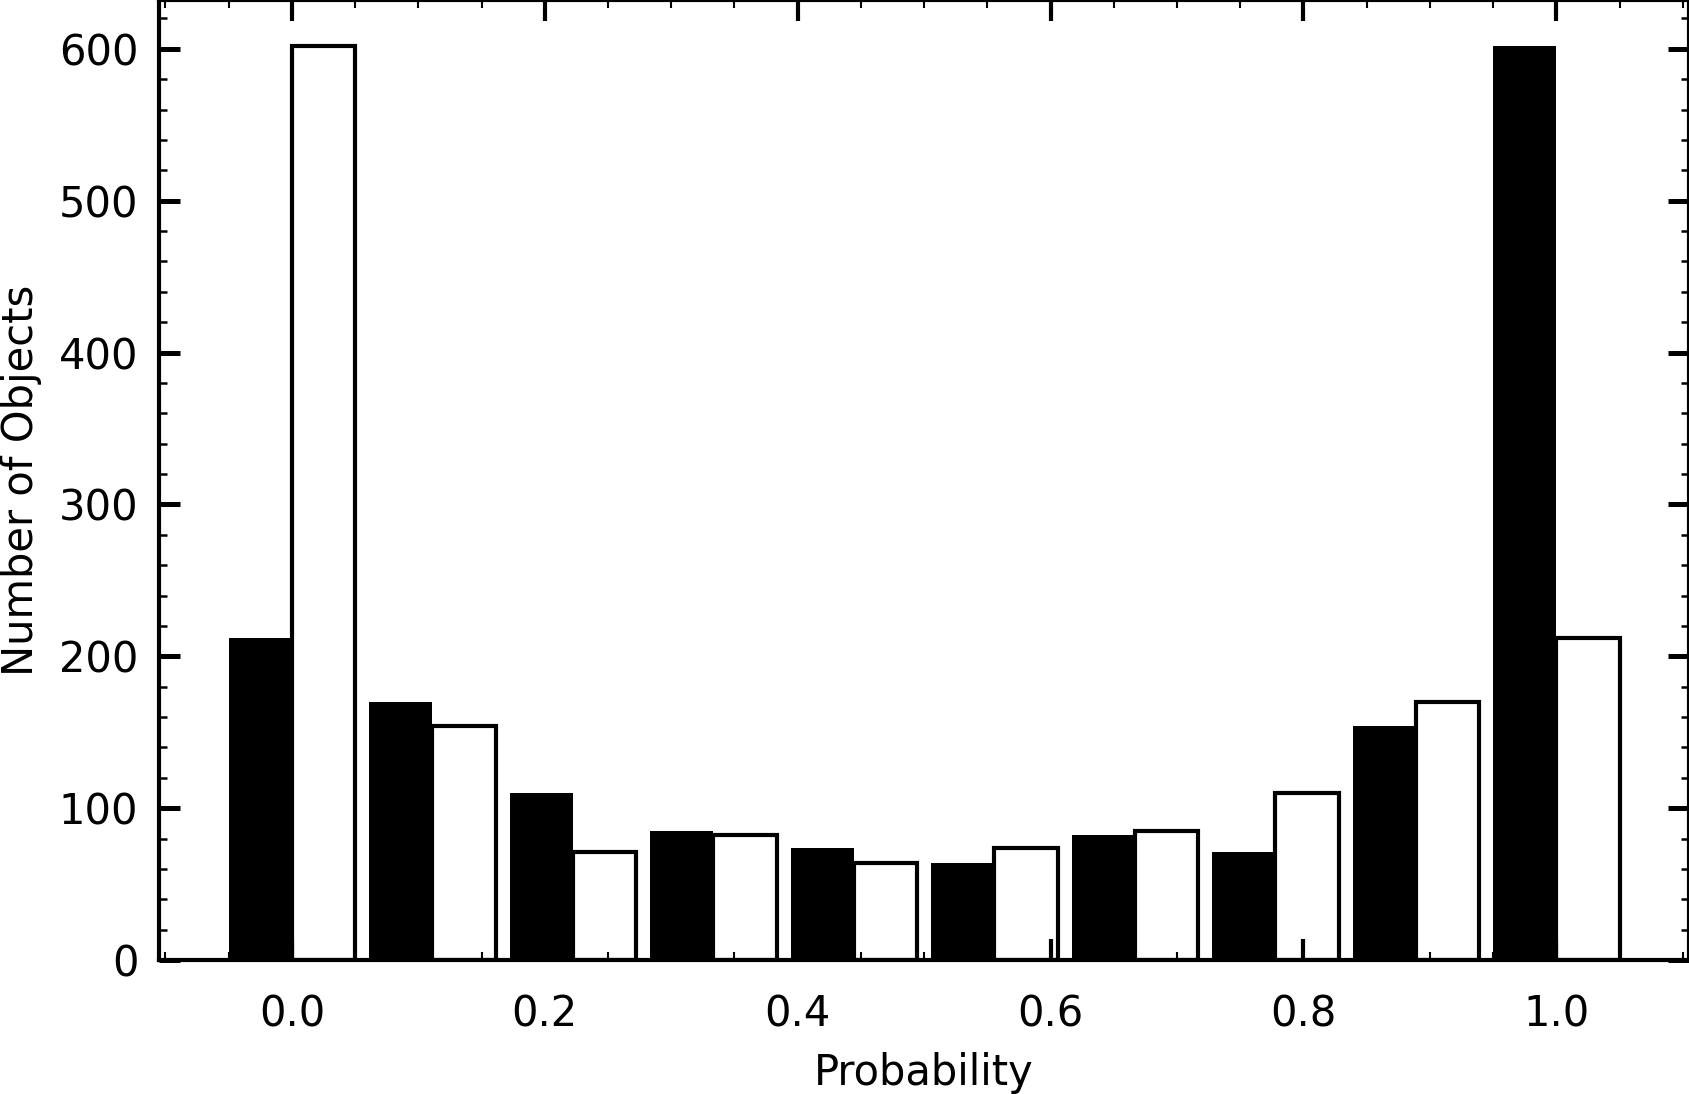

In [6]:
import matplotlib.pyplot as plt
#print(y_proba)
probs = pd.DataFrame(y_proba,columns=('p_1','p_2'))
bin_probs_1 = pd.cut(probs['p_1'],np.linspace(0,1,11),include_lowest=True)
bin_probs_2 = pd.cut(probs['p_2'],np.linspace(0,1,11),include_lowest=True)

print(x_test.shape)

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
x_axis = np.linspace(0,1,len(bin_probs_1.value_counts()))

ax.bar(x_axis-0.025,bin_probs_1.value_counts(sort=False), width=0.05,label='BLLs')
ax.bar(x_axis+0.025,bin_probs_2.value_counts(sort=False),width=0.05,label='FSRQs',color='white',edgecolor='black')
#ax.legend()
ax.set_xlabel('Probability')
ax.set_ylabel('Number of Objects')
ax.set_title('')

#plt.show()